# Работа с текстом

1. **Скачаем [датасет с фразами Симпсонов](https://github.com/sujanjoejacob/Text-mining-with-Simpsons-Data/tree/master)**

In [1]:
import pandas as pd

# Используем on_bad_lines для пропуска неправильных строк
script_lines = pd.read_csv("C:/Users/Yaros/Downloads/simpsons_script_lines/simpsons_script_lines.csv", 
                           on_bad_lines='skip', 
                           delimiter=",", 
                           low_memory=False)

# Отобразим первые строки, чтобы убедиться, что данные загружены корректно
script_lines.head()

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,true,464,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...,31.0
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,true,9,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3.0
2,9551,32,211,Miss Hoover: I don't know. Although I'd sure l...,856000,true,464,3.0,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sure like to talk t...,i dont know although id sure like to talk to h...,22.0
3,9552,32,212,Lisa Simpson: That life is worth living.,864000,true,9,3.0,Lisa Simpson,Springfield Elementary School,That life is worth living.,that life is worth living,5.0
4,9553,32,213,Edna Krabappel-Flanders: The polls will be ope...,864000,true,40,3.0,Edna Krabappel-Flanders,Springfield Elementary School,The polls will be open from now until the end ...,the polls will be open from now until the end ...,33.0


2. **Обучим word2vec на фразах персонажей**

In [2]:
from gensim.models import Word2Vec
import re

# Загрузка данных и предварительная обработка с использованием normalized_text
script_lines_clean = script_lines[['raw_character_text', 'normalized_text']].dropna()

# Функция для токенизации текста (если нормализованный текст ещё не разбит на слова)
def preprocess_text(text):
    return re.findall(r'\b\w+\b', text.lower())

# Токенизация нормализованного текста
script_lines_clean['tokens'] = script_lines_clean['normalized_text'].apply(preprocess_text)

# Обучение модели Word2Vec на нормализованном тексте
word2vec_model = Word2Vec(sentences=script_lines_clean['tokens'], vector_size=100, window=5, min_count=5, workers=4)

# Сохранение обученной модели
word2vec_model.save("simpsons_word2vec.model")

# Вывод информации об обученной модели
word2vec_model

3. **Визуализируем embeddings по самым частотным словам (top 1000)**

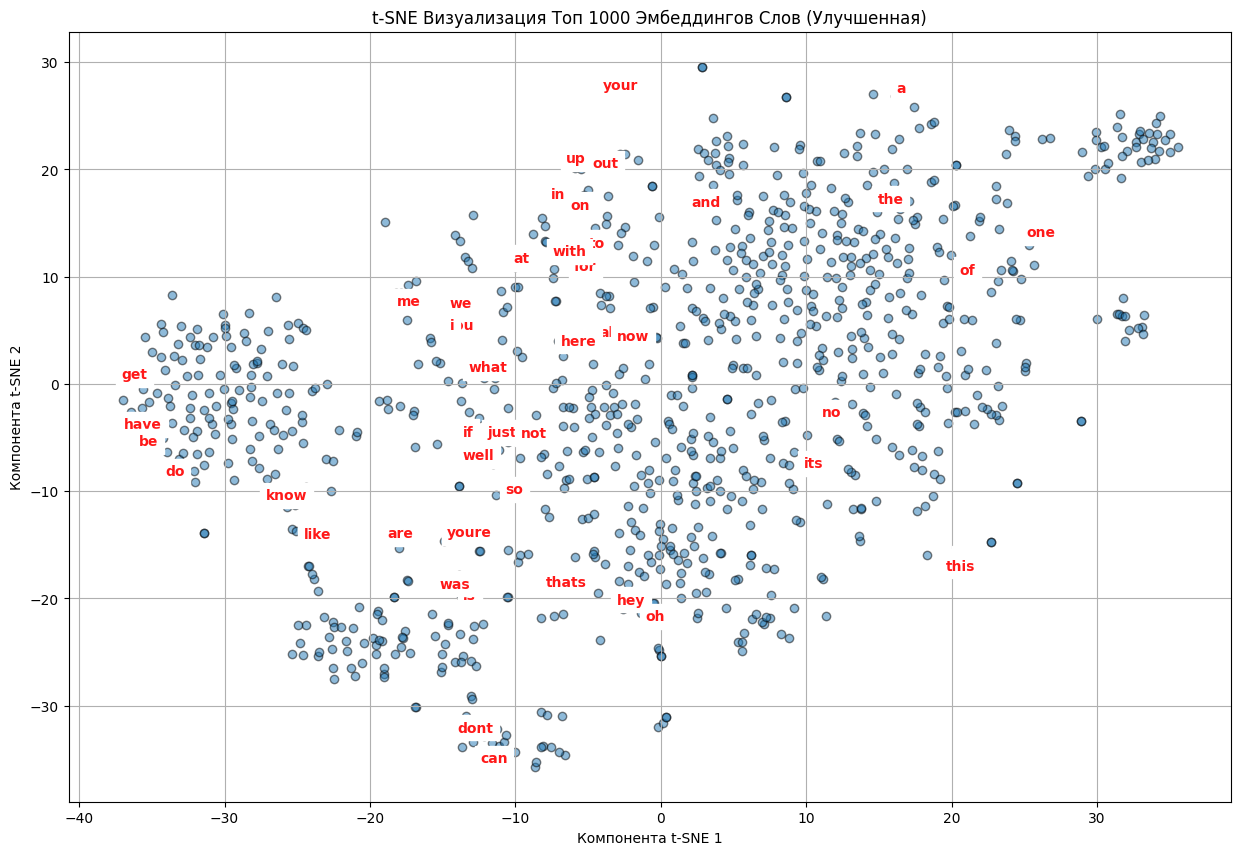

In [4]:
# Импорт библиотек для визуализации
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# 1. Получение 1000 самых частотных слов из модели
top_words = word2vec_model.wv.index_to_key[:1000]
word_vectors = np.array([word2vec_model.wv[word] for word in top_words])

# 2. Снижение размерности до 2D для визуализации с помощью t-SNE
tsne_reduced = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne_reduced.fit_transform(word_vectors)

# Улучшенная визуализация эмбеддингов слов
plt.figure(figsize=(15, 10))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], alpha=0.5, edgecolors='k')

# Аннотируем первые 50 слов с большим шрифтом и яркими цветами
for i, word in enumerate(top_words[:50]):
    plt.annotate(word, 
                 (reduced_vectors[i, 0], reduced_vectors[i, 1]), 
                 alpha=0.9, 
                 fontsize=10, 
                 color='red', 
                 backgroundcolor='white',
                 weight='bold')

plt.title("t-SNE Визуализация Топ 1000 Эмбеддингов Слов (Улучшенная)")
plt.xlabel("Компонента t-SNE 1")
plt.ylabel("Компонента t-SNE 2")
plt.grid(True)
plt.show()

4. **Найдём самые близкие слова для: homer - marge + bart bart - lisa + school marge - homer + home**

In [6]:
# Выполним операции с векторами для нахождения ближайших слов
analogies = {
    "homer - marge + bart": word2vec_model.wv.most_similar(positive=["homer", "bart"], negative=["marge"], topn=5),
    "bart - lisa + school": word2vec_model.wv.most_similar(positive=["bart", "school"], negative=["lisa"], topn=5),
    "marge - homer + home": word2vec_model.wv.most_similar(positive=["marge", "home"], negative=["homer"], topn=5)
}

analogies

{'homer - marge + bart': [('lisa', 0.7512534856796265),
  ('grampa', 0.6607488393783569),
  ('milhouse', 0.6433674693107605),
  ('abe', 0.5868029594421387),
  ('mrs', 0.5845551490783691)],
 'bart - lisa + school': [('church', 0.7537579536437988),
  ('game', 0.7185164093971252),
  ('house', 0.7180866599082947),
  ('town', 0.7029232978820801),
  ('plant', 0.6742888689041138)],
 'marge - homer + home': [('back', 0.7243055105209351),
  ('sleep', 0.6534585356712341),
  ('bed', 0.6496286392211914),
  ('dinner', 0.5941417217254639),
  ('together', 0.5760844349861145)]}

5. **Попробуем построить классификатор bart/lisa с использованием этих эмбеддингов**

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np

# 1. Отфильтруем данные для фраз Барта и Лизы
bart_lisa_lines = script_lines_clean[script_lines_clean['raw_character_text'].isin(['Bart Simpson', 'Lisa Simpson'])].copy()

# 2. Создадим метки: 0 для Барта, 1 для Лизы
label_encoder = LabelEncoder()
bart_lisa_lines.loc[:, 'label'] = label_encoder.fit_transform(bart_lisa_lines['raw_character_text'])

# Функция для вычисления среднего значения эмбеддингов слов в фразе
def average_word_vectors(tokens, model, vector_size=100):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

# 3. Создание признаков на основе эмбеддингов
X = bart_lisa_lines['tokens'].apply(lambda x: average_word_vectors(x, word2vec_model))
X = np.array(X.tolist())
y = bart_lisa_lines['label']

# 4. Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Построение и обучение классификатора
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 6. Оценка модели
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

report

'              precision    recall  f1-score   support\n\nBart Simpson       0.61      0.75      0.67      2560\nLisa Simpson       0.60      0.43      0.50      2195\n\n    accuracy                           0.60      4755\n   macro avg       0.60      0.59      0.59      4755\nweighted avg       0.60      0.60      0.59      4755\n'

- Точность (precision) для Барта: 0.61
- Точность для Лизы: 0.60
- Полнота (recall) для Барта: 0.75
- Полнота для Лизы: 0.43
- Общая точность модели: 0.60
- Среднее F1-значение (macro avg): 0.59